In [4]:
########### Real Estate ############


In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

C:\Users\samra\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Load the dataset
df = pd.read_csv("./world_real_estate_data(147k).csv")  


# --- Data Exploration ---

In [4]:
# Check the first few rows of the DataFrame
print(df.head())

# Check the columns of the DataFrame
print(df.columns)

# Strip any whitespace characters from the column names
df.columns = df.columns.str.strip()

                                               title   country  \
0  2 room apartment 120 m² in Mediterranean Regio...    Turkey   
1              4 room villa 500 m² in Kalkan, Turkey    Turkey   
2          1 room apartment 65 m² in Antalya, Turkey    Turkey   
3             1 room apartment  in Pattaya, Thailand  Thailand   
4             2 room apartment  in Pattaya, Thailand  Thailand   

                                    location  building_construction_year  \
0               Mediterranean Region, Turkey                         NaN   
1  Kalkan, Mediterranean Region, Kas, Turkey                      2021.0   
2      Mediterranean Region, Antalya, Turkey                         NaN   
3      Chon Buri Province, Pattaya, Thailand                      2020.0   
4      Chon Buri Province, Pattaya, Thailand                      2026.0   

   building_total_floors  apartment_floor  apartment_rooms  \
0                    5.0              1.0              3.0   
1                    2

# --- Initial Data Visualization ---

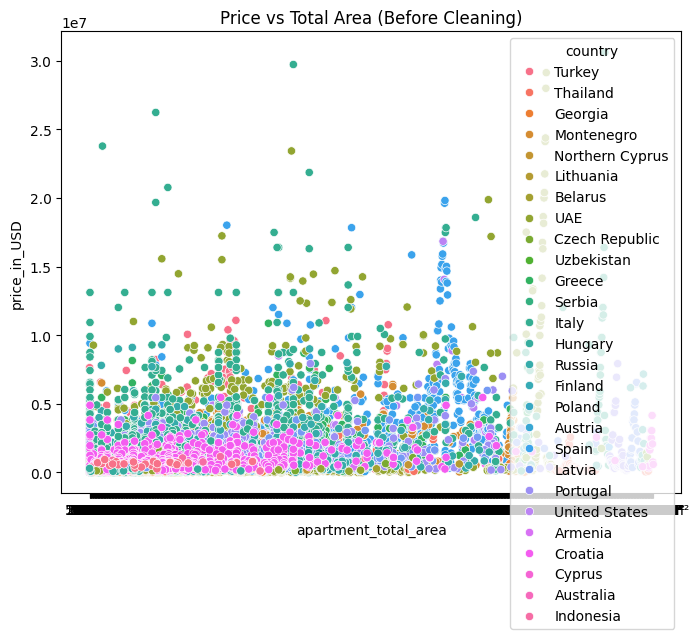

In [5]:
# Scatter plots to visualize the data before cleaning
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='apartment_total_area', y='price_in_USD', hue='country')
plt.title("Price vs Total Area (Before Cleaning)")
plt.show()

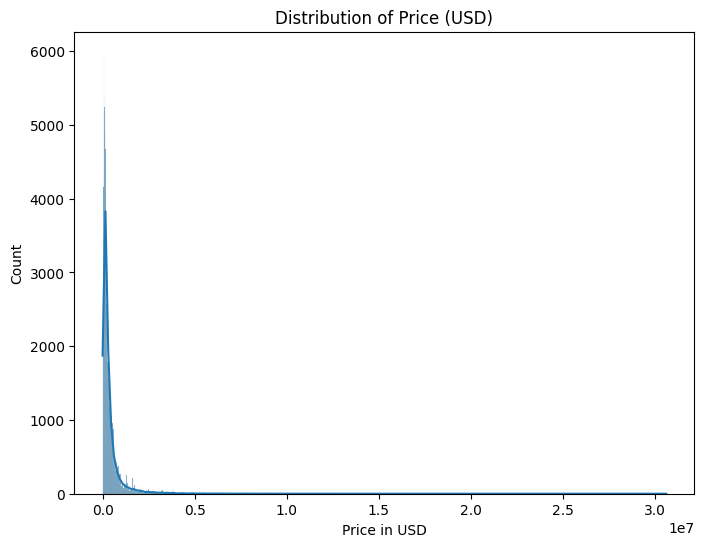

In [6]:
# Distribution plot of the target variable
plt.figure(figsize=(8, 6))
sns.histplot(df['price_in_USD'], kde=True)
plt.title("Distribution of Price (USD)")
plt.xlabel("Price in USD")
plt.show()

# --- Data Preprocessing ---

In [7]:
# Preprocess the data
# Initial Data Cleaning
df.dropna(inplace=True)

# Convert categorical columns
categorical_columns = ['country', 'location']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)


In [8]:
# Function to convert area columns to numeric
def convert_area_to_numeric(area_column):
    return area_column.str.replace(' m²', '', regex=False).str.replace(' ', '').astype(float)

# Apply conversion to area columns
df['apartment_total_area'] = convert_area_to_numeric(df['apartment_total_area'])
df['apartment_living_area'] = convert_area_to_numeric(df['apartment_living_area'])


# --- Handle Outliers ---

In [9]:
# Function to cap outliers in a given column
def cap_outliers(column):
    lower_bound = column.quantile(0.05)
    upper_bound = column.quantile(0.95)
    return column.clip(lower_bound, upper_bound)


In [10]:
# Cap outliers for numeric columns
df['price_in_USD'] = cap_outliers(df['price_in_USD'])
df['apartment_total_area'] = cap_outliers(df['apartment_total_area'])
df['apartment_living_area'] = cap_outliers(df['apartment_living_area'])


# --- Feature Engineering ---

In [11]:
# Create a new feature: price per square meter
df['price_per_m2'] = df['price_in_USD'] / df['apartment_total_area']

In [12]:
# Scaling numeric features
numeric_features = ['apartment_total_area', 'apartment_living_area', 'price_per_m2', 'apartment_bedrooms', 'apartment_bathrooms']
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# --- Data Visualization After Cleaning ---

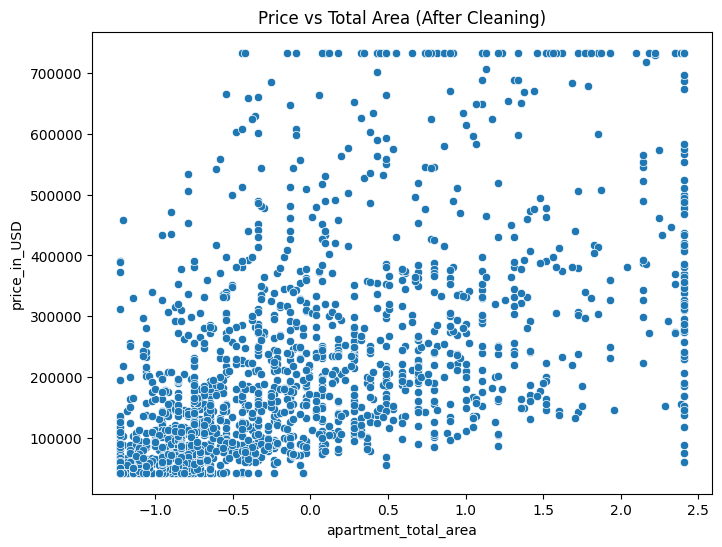

In [13]:
# Scatter plot to visualize data after cleaning
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='apartment_total_area', y='price_in_USD')
plt.title("Price vs Total Area (After Cleaning)")
plt.show()

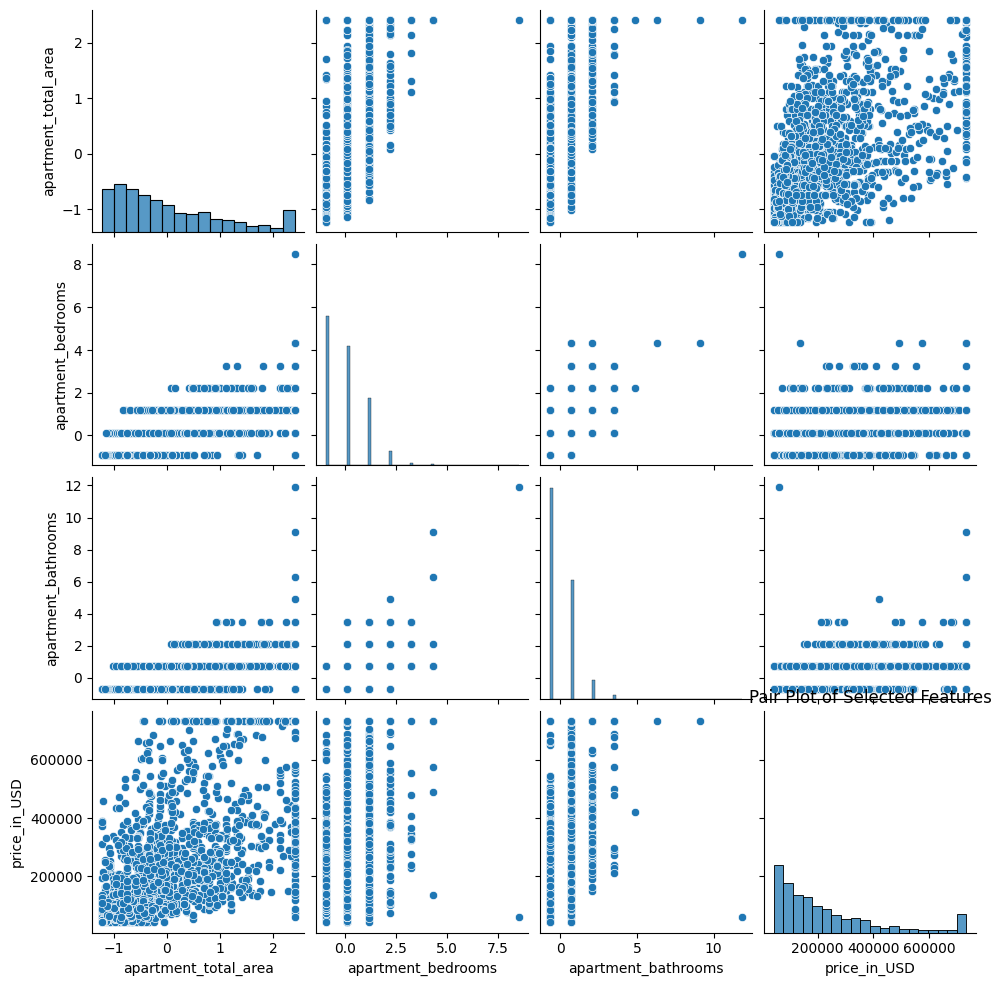

In [14]:
# Pair plot
subset_features = df[['apartment_total_area', 'apartment_bedrooms', 'apartment_bathrooms', 'price_in_USD']]
sns.pairplot(subset_features)
plt.title("Pair Plot of Selected Features")
plt.show()

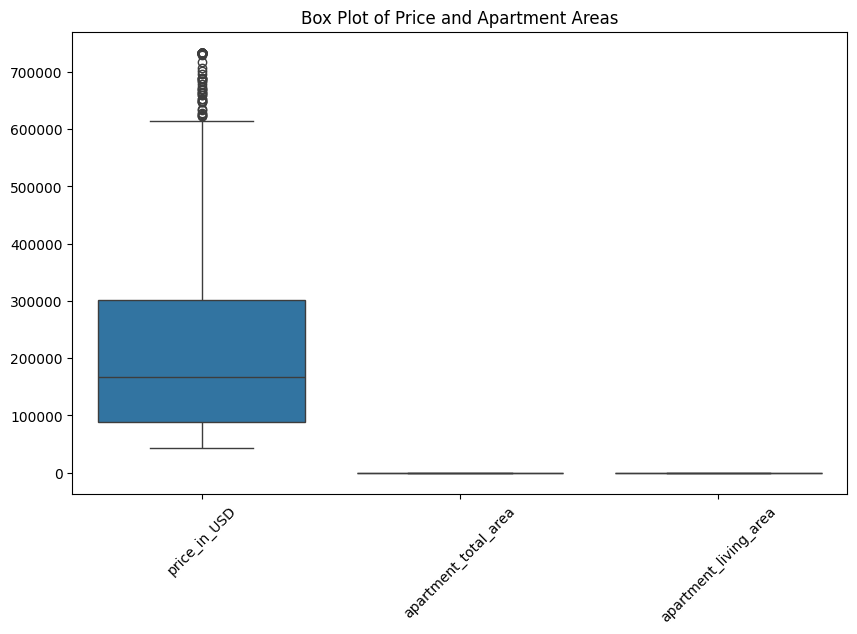

In [15]:
# Box Plot for Outlier Detection
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['price_in_USD', 'apartment_total_area', 'apartment_living_area']])
plt.title("Box Plot of Price and Apartment Areas")
plt.xticks(rotation=45)
plt.show()

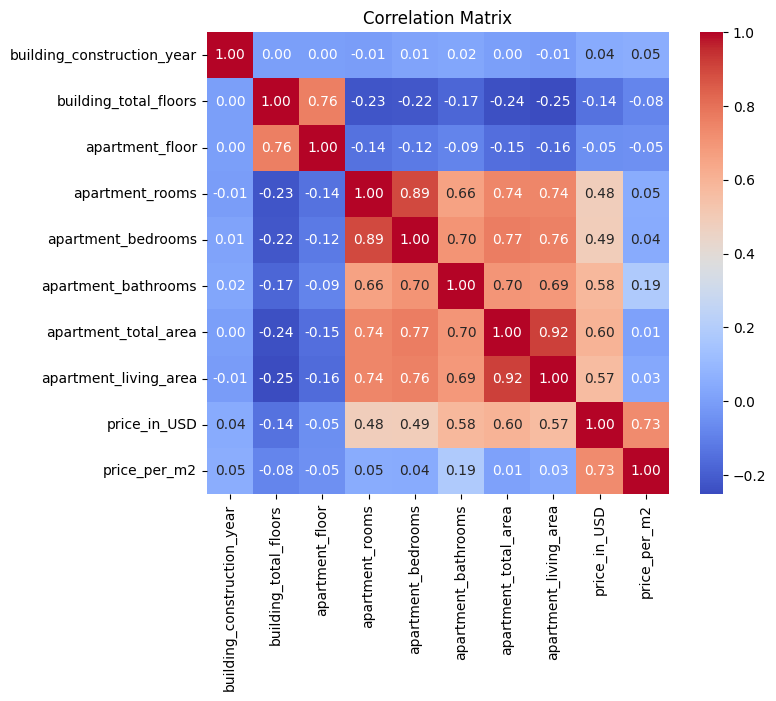

In [16]:
# Heatmap of the Entire Correlation Matrix


# Dynamically select all numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation matrix with the numeric columns
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=True)
plt.title("Correlation Matrix")
plt.show()


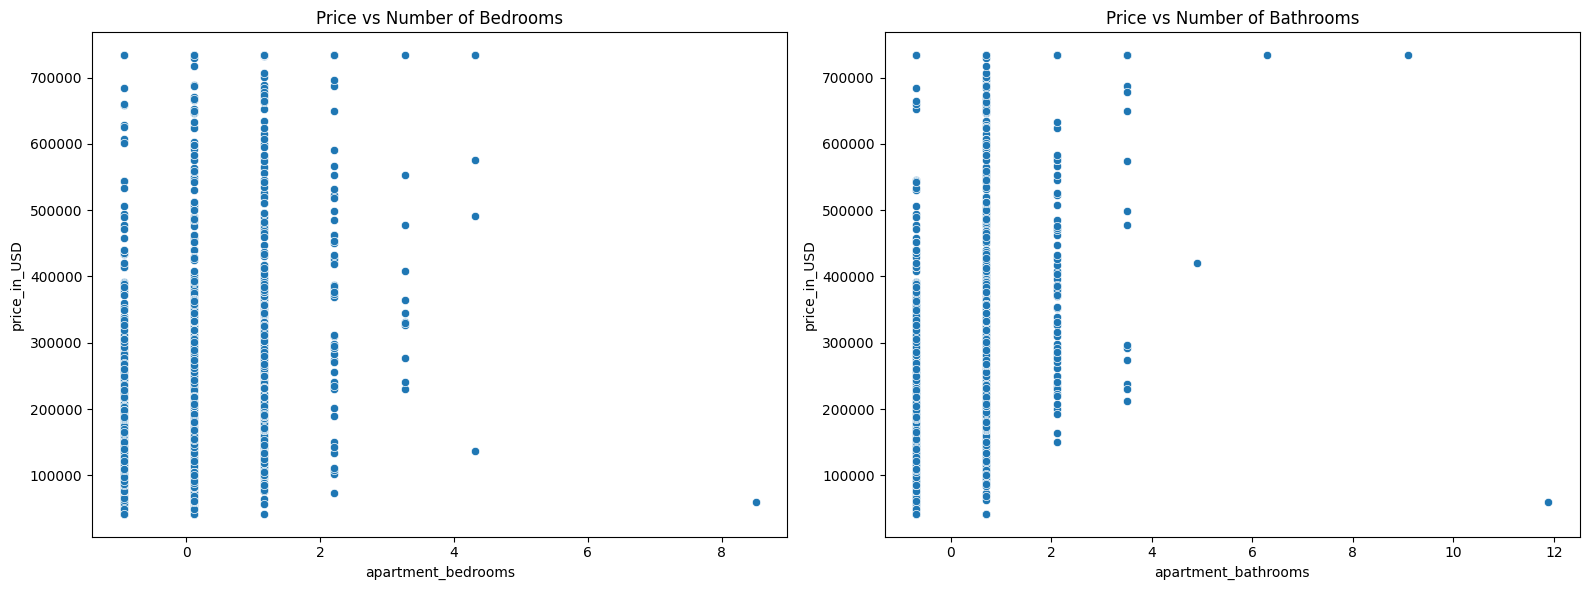

In [17]:
# Scatter Plots of Price vs Number of Bedrooms and Bathrooms side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot for Bedrooms
sns.scatterplot(data=df, x='apartment_bedrooms', y='price_in_USD', ax=axes[0])
axes[0].set_title("Price vs Number of Bedrooms")

# Scatter plot for Bathrooms
sns.scatterplot(data=df, x='apartment_bathrooms', y='price_in_USD', ax=axes[1])
axes[1].set_title("Price vs Number of Bathrooms")

plt.tight_layout()
plt.show()


In [18]:
# Bar Plot of Average Price by Country

# # Reverse the dummy columns to recreate the 'country' column
# df['country'] = df.filter(like='country_').idxmax(axis=1).str.replace('country_', '')

# avg_price_by_country = df.groupby('country')['price_in_USD'].mean().sort_values()
# plt.figure(figsize=(10, 6))
# avg_price_by_country.plot(kind='barh')
# plt.title("Average Price by Country")
# plt.xlabel("Average Price (USD)")
# plt.show()

# --- Prepare Data for Modeling ---

In [40]:
# Define features and target variable
X = df.drop(columns=['price_in_USD', 'title', 'image', 'url'])
y = df['price_in_USD']

In [71]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a list to store evaluation metrics for each model
evaluation_metrics = []

# --- Model Training ---

#### Implementing Linear Regression

In [72]:
# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

# Add metrics to the list

evaluation_metrics.append({
    'Model': 'Linear Regression', 
    'MSE': round(mse, 4), 
    'MAE': round(mae, 4), 
    'R-squared': round(r2, 4)
})


Mean Squared Error: 10885266215618723395647045632.0000
Mean Absolute Error: 14599488110248.4824
R-squared: -319571418145649664.0000


#### Implementing Random Forest 

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest Mean Squared Error: {mse_rf:.4f}')
print(f'Random Forest Mean Absolute Error: {mae_rf:.4f}')
print(f'Random Forest R-squared: {r2_rf:.4f}')

# Add metrics to the list
evaluation_metrics.append({'Model': 'Random Forest', 'MSE': round(mse_rf, 4), 'MAE': round(mae_rf, 4), 'R-squared': round(r2_rf, 4)})

Random Forest Mean Squared Error: 126363732.7867
Random Forest Mean Absolute Error: 5950.3797
Random Forest R-squared: 0.9963


#### Implementing Optimised Random Forest 

In [74]:
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("Feature Importances:\n", feature_importances)


Feature Importances:
 price_per_m2                                                      0.658177
apartment_total_area                                              0.327545
apartment_living_area                                             0.005349
apartment_bathrooms                                               0.004010
building_total_floors                                             0.000744
                                                                    ...   
location_Hrodna Region, Shchuchyn, Shchuchyn District, Belarus    0.000000
location_Hrodna Region, Lida, Lida District, Belarus              0.000000
location_Adlia, Abkhazia, Batumi, Georgia                         0.000000
location_Uemraniye, Marmara Region, Turkey                        0.000000
location_Radovici, Tivat Municipality, Montenegro                 0.000000
Length: 314, dtype: float64


In [75]:
# Define a threshold for feature importance (e.g., 0.001)
threshold = 0.001

# Get the feature importances from the Random Forest model
importances = rf_model.feature_importances_

# Create a list of columns to drop based on the threshold
columns_to_drop = [col for col, importance in zip(X.columns, importances) if importance < threshold]

# Drop those columns from the DataFrame
df_cleaned = df.drop(columns=columns_to_drop)

# Re-split the data
X_cleaned = df_cleaned.drop(columns=['price_in_USD', 'title', 'image', 'url'])
y_cleaned = df_cleaned['price_in_USD']
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)


In [76]:
from sklearn.model_selection import GridSearchCV

# Define the model
rf_model = RandomForestRegressor(random_state=42)

# Hyperparameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [10, 20, None],  # Max depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples in leaf nodes
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train_cleaned, y_train_cleaned)

# Get the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: -178857934.48815718


In [78]:
# Retrain the model using the best hyperparameters
best_rf_model = grid_search.best_estimator_

# Fit the model on the training data
best_rf_model.fit(X_train_cleaned, y_train_cleaned)

# Make predictions
y_pred_rf_best = best_rf_model.predict(X_test_cleaned)

# Evaluate the model
mse_rf_best = mean_squared_error(y_test_cleaned, y_pred_rf_best)
mae_rf_best = mean_absolute_error(y_test_cleaned, y_pred_rf_best)
r2_rf_best = r2_score(y_test_cleaned, y_pred_rf_best)

print(f'Optimized Random Forest Mean Squared Error: {mse_rf_best:.4f}')
print(f'Optimized Random Forest Mean Absolute Error: {mae_rf_best:.4f}')
print(f'Optimized Random Forest R-squared: {r2_rf_best:.4f}')

# Add metrics to the list
evaluation_metrics.append({'Model': 'Optimized Random Forest', 'MSE': round(mse_rf_best, 4), 'MAE': round(mae_rf_best, 4), 'R-squared': round(r2_rf_best, 4)})



Optimized Random Forest Mean Squared Error: 89248794.8206
Optimized Random Forest Mean Absolute Error: 4898.2512
Optimized Random Forest R-squared: 0.9974


#### Implementing Neural Network Regression

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample

X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned

#scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cleaned)
X_test_scaled = scaler.transform(X_test_cleaned)

#building the neural network model
nn_model = MLPRegressor(
    hidden_layer_sizes=(64, 32),  # Simpler architecture
    activation='relu',
    solver='adam',  # Optimizer for faster convergence
    batch_size=32,  # Smaller batch size for faster updates
    learning_rate_init=0.01,  # Adjust learning rate
    max_iter=1000,  # Max iterations to allow convergence
    early_stopping=True,  # Enable early stopping
    random_state=42
)

#training the model
nn_model.fit(X_train_scaled, y_train_cleaned)

#predict on test data
y_pred_nn = nn_model.predict(X_test_scaled)

#evaluate the model
mse_nn = mean_squared_error(y_test_cleaned, y_pred_nn)
mae_nn = mean_absolute_error(y_test_cleaned, y_pred_nn) 
r2_nn = r2_score(y_test_cleaned, y_pred_nn)

print(f'Neural Network Mean Squared Error: {mse_nn:.4f}')
print(f'Neural Network Mean Absolute Error: {mae_nn:.4f}')
print(f'Neural Network R-squared: {r2_nn:.4f}')

# Add metrics to the list
evaluation_metrics.append({'Model': 'Neural Network', 'MSE': round(mse_nn, 4), 'MAE': round(mae_nn, 4), 'R-squared': round(r2_nn, 4)})


Neural Network Mean Squared Error: 4763126626.3159
Neural Network Mean Absolute Error: 34726.4020
Neural Network R-squared: 0.8602


#### Implementing Tuned Neural Network

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor

def test_hyperparameters(X_train_scaled, y_train_cleaned, X_test_scaled, y_test_cleaned):
    # Define hyperparameter grid
    param_grid = {
        'learning_rate_init': [0.001, 0.01, 0.1],  # Smaller learning rates
        'alpha': [0.0001, 0.001, 0.01],  # L2 regularization strength
        'batch_size': [16, 32, 64, 128, 256],  # Different batch sizes
        'max_iter': [10000]  # Set to a high number for sufficient training time
    }

    #initialize the neural network model
    nn_model = MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        random_state=42
    )

    #perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(nn_model, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

    #fit the model
    grid_search.fit(X_train_scaled, y_train_cleaned)

    #best model after hyperparameter tuning
    best_model = grid_search.best_estimator_

    #predict on the test data
    y_pred_nn_tuned = best_model.predict(X_test_scaled)

    #evaluate the model
    mse_nn_tuned = mean_squared_error(y_test_cleaned, y_pred_nn_tuned)
    mae_nn_tuned = mean_absolute_error(y_test_cleaned, y_pred_nn_tuned)  
    r2_nn_tuned = r2_score(y_test_cleaned, y_pred_nn_tuned)

    print(f'Best Hyperparameters: {grid_search.best_params_}')
    print(f'Mean Squared Error (MSE): {mse_nn_tuned:.4f}')
    print(f'Mean Absolute Error (MAE): {mae_nn_tuned:.4f}')
    print(f'R² Score: {r2_nn_tuned:.4f}')

    # Add metrics to the list
    evaluation_metrics.append({'Model': 'Tuned Neural Network', 'MSE': round(mse_nn_tuned, 4), 'MAE': round(mae_nn_tuned, 4), 'R-squared': round(r2_nn_tuned, 4)})
    
    return y_pred_nn_tuned


y_pred_nn_tuned=test_hyperparameters(X_train_scaled, y_train_cleaned, X_test_scaled, y_test_cleaned)


Best Hyperparameters: {'alpha': 0.01, 'batch_size': 128, 'learning_rate_init': 0.001, 'max_iter': 10000}
Mean Squared Error (MSE): 5182974525.6027
Mean Absolute Error (MAE): 40189.9029
R² Score: 0.8478


#### Implementing Stacking Model

In [88]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Assume best_rf_model is already fitted, as per your previous code
best_rf_model = grid_search.best_estimator_

# Build the neural network model (you can adjust the architecture or hyperparameters here)
nn_model = MLPRegressor(
    hidden_layer_sizes=(64, 32),  # Simplified architecture
    activation='relu',
    solver='adam',
    batch_size=32,
    learning_rate_init=0.01,
    max_iter=1000,
    early_stopping=True,
    random_state=42
)

# Create the stacking model with Random Forest and Neural Network as base learners
stack_model = StackingRegressor(
    estimators=[
        ('rf', best_rf_model),  # Best Random Forest model
        ('nn', nn_model)        # Neural network model
    ],
    final_estimator=RandomForestRegressor()  # Meta-model: another Random Forest
)

# Train the stacked model
stack_model.fit(X_train_cleaned, y_train_cleaned)

# Make predictions with the stacked model
y_pred_stack = stack_model.predict(X_test_cleaned)

mse_stack = mean_squared_error(y_test_cleaned, y_pred_stack)
mae_stack = mean_absolute_error(y_test_cleaned, y_pred_stack)
r2_stack = r2_score(y_test_cleaned, y_pred_stack)

print(f'Stacking Model Mean Squared Error: {mse_stack:.4f}')
print(f'Stacking Model Mean Absolute Error: {mae_stack:.4f}')
print(f'Stacking Model R-squared: {r2_stack:.4f}')

# Add metrics to the list
evaluation_metrics.append({'Model': 'Stacking Model', 'MSE': round(mse_stack, 4), 'MAE': round(mae_stack, 4), 'R-squared': round(r2_stack, 4)})

Stacking Model Mean Squared Error: 140202606.7279
Stacking Model Mean Absolute Error: 5972.7290
Stacking Model R-squared: 0.9959


#### Evaluation Metrics Comparison

In [89]:
# Convert the evaluation metrics list to a DataFrame and print the tabular comparison
evaluation_df = pd.DataFrame(evaluation_metrics)
print("\nEvaluation Metrics Comparison:")
print(evaluation_df)


Evaluation Metrics Comparison:
                     Model           MSE           MAE     R-squared
0        Linear Regression  1.088527e+28  1.459949e+13 -3.195714e+17
1            Random Forest  1.263637e+08  5.950380e+03  9.963000e-01
2  Optimized Random Forest  8.924879e+07  4.898251e+03  9.974000e-01
3           Neural Network  4.763127e+09  3.472640e+04  8.602000e-01
4     Tuned Neural Network  5.182975e+09  4.018990e+04  8.478000e-01
5           Stacking Model  1.466284e+08  5.921303e+03  9.957000e-01
6     Tuned Neural Network  5.182975e+09  4.018990e+04  8.478000e-01
7           Stacking Model  1.402026e+08  5.972729e+03  9.959000e-01


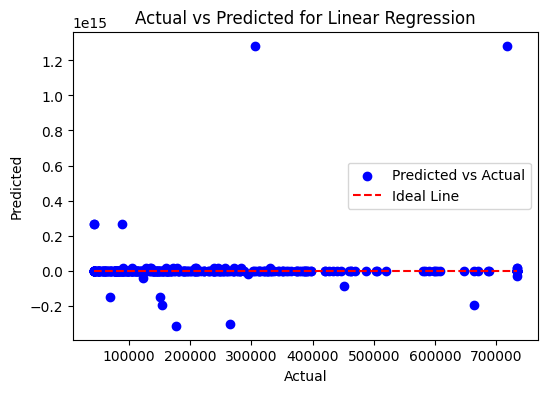

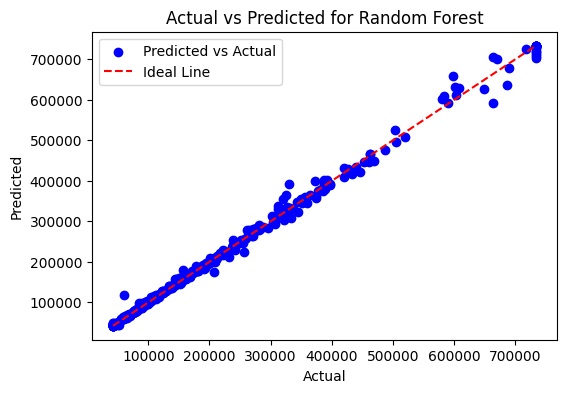

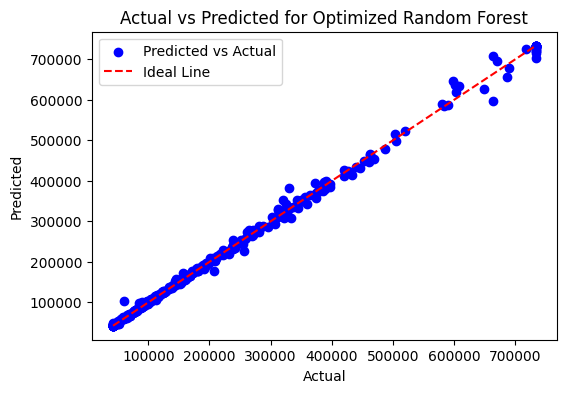

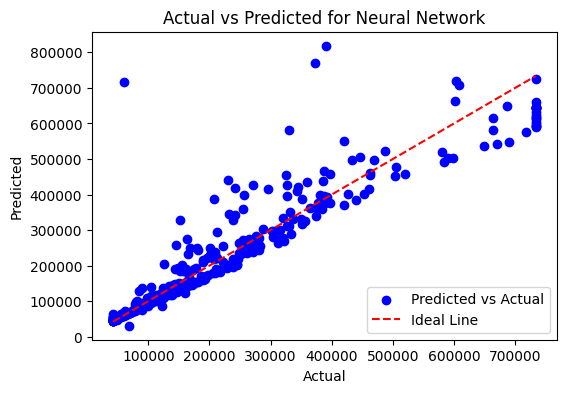

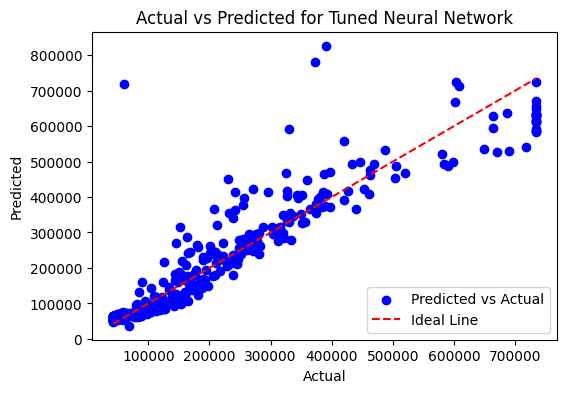

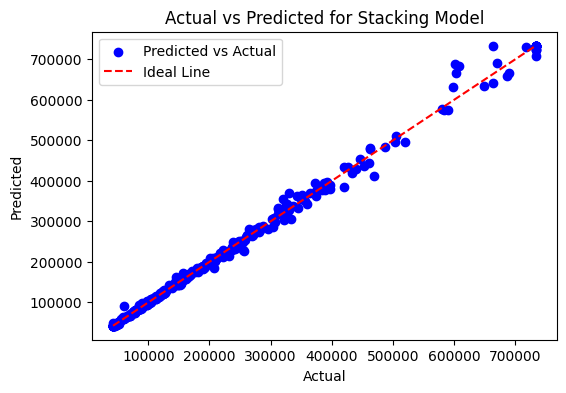

In [90]:
import matplotlib.pyplot as plt

# Function to plot Actual vs Predicted values
def plot_actual_vs_predicted(y_actual, y_pred, model_name):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_actual, y_pred, color='blue', label='Predicted vs Actual')
    plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--', label='Ideal Line')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted for {model_name}')
    plt.legend()
    plt.show()

# Linear Regression Plot
plot_actual_vs_predicted(y_test, y_pred, 'Linear Regression')

# Random Forest Plot
plot_actual_vs_predicted(y_test, y_pred_rf, 'Random Forest')

# Optimized Random Forest Plot
plot_actual_vs_predicted(y_test_cleaned, y_pred_rf_best, 'Optimized Random Forest')

# Neural Network Plot
plot_actual_vs_predicted(y_test_cleaned, y_pred_nn, 'Neural Network')

# Tuned Neural Network Plot
plot_actual_vs_predicted(y_test_cleaned, y_pred_nn_tuned, 'Tuned Neural Network')

# Stacking Model Plot
plot_actual_vs_predicted(y_test_cleaned, y_pred_stack, 'Stacking Model')
